In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np
import os
# import pandas as pd

## Dataset preparation

### Set parameters

In [4]:
batch_size = 32
img_height = 184
img_width = 216
img_size = (img_height, img_width)
img_shape = img_size + (3,)

### Load dataset

In [5]:
from tensorflow.keras.utils import image_dataset_from_directory

train_path = "/drive0-storage/Gracia/Dataset/dataset_5/training"
val_path = "/drive0-storage/Gracia/Dataset/dataset_5/validation"

with tf.device("CPU"):
    train_ds = image_dataset_from_directory(train_path,
                                        seed = 123,
                                        image_size = img_size,
                                        batch_size = batch_size)
    
    val_ds = image_dataset_from_directory(val_path,
                                      seed = 456,
                                      image_size = img_size,
                                      batch_size = batch_size)

2023-06-15 14:12:36.376376: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-15 14:12:37.003058: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38215 MB memory:  -> device: 0, name: A100-SXM4-40GB MIG 7g.40gb, pci bus id: 0000:0f:00.0, compute capability: 8.0


Found 16332 files belonging to 3 classes.
Found 4080 files belonging to 3 classes.


In [6]:
# os.rmdir("/drive0-storage/Gracia/dataset_1/.ipynb_checkpoints")

In [7]:
class_names = train_ds.class_names
num_classes = len(class_names)

print(class_names)

['bipolar_disorder', 'healthy_controls', 'schizophrenia']


In [ ]:
## with tf.device("CPU"):
    plt.figure(figsize=(7,5))
    for images, labels in train_ds.take(1):
        org_image = images[31]
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.axis("off")

    print(org_image.dtype)
    print(np.min(org_image), np.max(org_image))
    print(org_image.shape)

### Test set

In [41]:
with tf.device("CPU"):
    val_batches = tf.data.experimental.cardinality(val_ds)
    test_dataset = val_ds.take(val_batches // 2)
    validation_dataset = val_ds.skip(val_batches // 2)
    
    # Buffered prefetching
    AUTOTUNE = tf.data.AUTOTUNE
    train_dataset = train_ds.prefetch(buffer_size = AUTOTUNE)
    validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)
    test_dataset = test_dataset.prefetch(buffer_size = AUTOTUNE)

In [10]:
print(len(validation_dataset))
print(len(test_dataset))

64
64


## Model building

In [42]:
def build_vgg16():
    model = Sequential()
    
    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=img_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#     model.add(Dropout(0.2))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#     model.add(Dropout(0.2))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#     model.add(Dropout(0.2))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#     model.add(Dropout(0.2))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#     model.add(Dropout(0.2))

    # Flatten the output and create fully connected layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))  
    
    return model

In [43]:
with tf.device("GPU"):
    model = build_vgg16()
    # compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
                  metrics=['accuracy'])

## Model training

In [44]:
# Callback function
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.99):
            print("\nReached 99% accuracy, cancelling training")
            self.model.stop_training = True
            
callbacks = myCallback()
save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
checkpoints_cb = tf.keras.callbacks.ModelCheckpoint('./cnn5_checkpoints', options=save_locally)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

In [45]:
EPOCH = 30

history = model.fit(
            train_dataset,
            validation_data = validation_dataset,
            epochs = EPOCH,
            batch_size = 32,
            callbacks=[callbacks])

Epoch 1/30


2023-06-15 14:14:59.905574: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-15 14:15:00.911913: I tensorflow/stream_executor/cuda/cuda_blas.cc:1633] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


511/511 [==============================] - 31s 54ms/step - loss: 1.0702 - accuracy: 0.4094 - val_loss: 1.1028 - val_accuracy: 0.3656
Epoch 2/30
511/511 [==============================] - 27s 52ms/step - loss: 0.9184 - accuracy: 0.5588 - val_loss: 1.0348 - val_accuracy: 0.4695
Epoch 3/30
511/511 [==============================] - 27s 52ms/step - loss: 0.7173 - accuracy: 0.6773 - val_loss: 0.8761 - val_accuracy: 0.5748
Epoch 4/30
511/511 [==============================] - 26s 52ms/step - loss: 0.5514 - accuracy: 0.7667 - val_loss: 0.8014 - val_accuracy: 0.6363
Epoch 5/30
511/511 [==============================] - 27s 52ms/step - loss: 0.4022 - accuracy: 0.8388 - val_loss: 0.6214 - val_accuracy: 0.7229
Epoch 6/30
511/511 [==============================] - 26s 52ms/step - loss: 0.2616 - accuracy: 0.8995 - val_loss: 0.5340 - val_accuracy: 0.7987
Epoch 7/30
511/511 [==============================] - 27s 52ms/step - loss: 0.1542 - accuracy: 0.9456 - val_loss: 0.4199 - val_accuracy: 0.8440
Epo

In [46]:
# model.save('./models/cnn5_13epoch.h5')

In [4]:
# model = tf.keras.models.load_model('./models/cnn5_30epoch.h5')

### Training evaluation

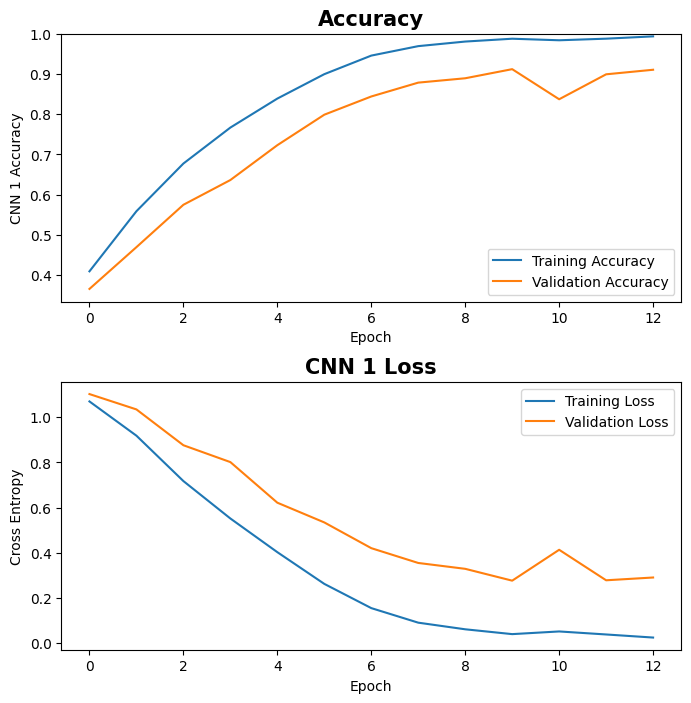

In [58]:
plt.figure(figsize=(8, 8))

# training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('CNN 1 Accuracy')
plt.xlabel('Epoch')
plt.ylim([min(plt.ylim()),1])
plt.title('Accuracy', size=15, fontweight='bold')
plt.savefig('acc_cnn1.png')

# training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
# plt.ylim([0,1.0])
plt.title('CNN 1 Loss', size=15, fontweight='bold')
plt.savefig('loss_cnn1.png')

plt.subplots_adjust(hspace=0.3)
plt.show()

In [48]:
acc

[0.40938034653663635,
 0.558780312538147,
 0.6773205995559692,
 0.7667156457901001,
 0.838782787322998,
 0.8994612097740173,
 0.9456282258033752,
 0.969140350818634,
 0.9805290102958679,
 0.9875704050064087,
 0.9837129712104797,
 0.9876928925514221,
 0.9934484362602234]

In [49]:
val_acc

[0.36564961075782776,
 0.4694882035255432,
 0.5748031735420227,
 0.6363189220428467,
 0.7229330539703369,
 0.7987204790115356,
 0.8439960479736328,
 0.8784449100494385,
 0.8892716765403748,
 0.9119094610214233,
 0.8371062874794006,
 0.899114191532135,
 0.9104330539703369]

In [50]:
loss

[1.0701719522476196,
 0.9183838963508606,
 0.7172512412071228,
 0.5514174103736877,
 0.40216177701950073,
 0.2616022527217865,
 0.15424275398254395,
 0.08972173929214478,
 0.060361988842487335,
 0.03894045203924179,
 0.05081045627593994,
 0.03742074593901634,
 0.02378218248486519]

In [51]:
val_loss

[1.1028287410736084,
 1.0348126888275146,
 0.8760641813278198,
 0.8013588786125183,
 0.6214134693145752,
 0.5339840054512024,
 0.41993919014930725,
 0.3543066680431366,
 0.3283444344997406,
 0.27587035298347473,
 0.41275399923324585,
 0.27757182717323303,
 0.28988537192344666]

## Testing

In [52]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns

In [53]:
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names, result))

64/64 [==============================] - 1s 20ms/step - loss: 0.2806 - accuracy: 0.9131


{'loss': 0.2805817127227783, 'accuracy': 0.9130859375}

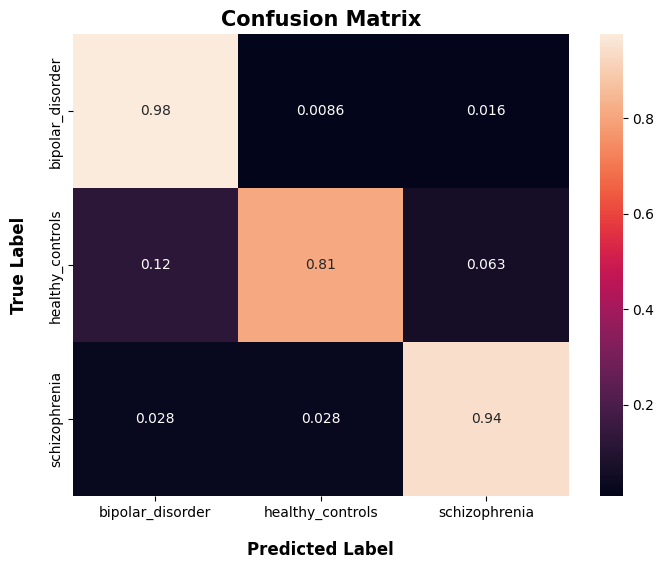

In [56]:
predicted = []  # predicted labels
true = []  # true labels

for image_batch, label_batch in test_dataset:  
    true.append(label_batch)
    prediction = model.predict(image_batch, verbose=0)
    predicted.append(np.argmax(prediction, axis=-1))

# convert labels into tensors
true_labels = tf.concat([item for item in true], axis=0)
predicted_labels = tf.concat([item for item in predicted], axis=0)

cf_matrix = confusion_matrix(true_labels, predicted_labels, normalize='true')

# plot confusion  matrix
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.heatmap(cf_matrix, 
            annot=True)
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.xlabel('Predicted Label', labelpad=15, size=12, fontweight='bold')
plt.ylabel('True Label', labelpad=15, size=12, fontweight='bold')
plt.title('Confusion Matrix', size=15, fontweight='bold')
plt.savefig('./CNN5_cm.png')
plt.show()

In [57]:
precision = precision_score(true_labels, predicted_labels, average='weighted')
sensitivity = recall_score(true_labels, predicted_labels, average='weighted')
specificity = []
for i in range(num_classes):
    true_negatives = np.sum(np.delete(np.delete(cf_matrix, i, axis=0), i, axis=1))
    false_positives = np.sum(cf_matrix[:, i]) - cf_matrix[i, i]
    specificity.append(true_negatives / (true_negatives + false_positives))

# Calculate average specificity
average_specificity = np.mean(specificity)

print("Accuracy:", result[1])
print("Precision:", precision)
print("Sensitivity:", sensitivity)
print("Specificity:", average_specificity)

Accuracy: 0.9130859375
Precision: 0.9147256739140209
Sensitivity: 0.91064453125
Specificity: 0.9551639893253476
